In [ ]:

from utils.check_image import check_image
import nibabel as nib

image = nib.load(f"data/nnunet_raw/Dataset001_raw_aaa/imagesTs/aaa_016_0000.nii.gz").get_fdata()
ground_truth = nib.load(f"data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_016.nii.gz").get_fdata()
label0 = nib.load(f"data/nnunet_raw/Dataset001_raw_aaa/outputTs/aaa_016.nii.gz").get_fdata()
label1 = nib.load(f"data/nnunet_raw/Dataset002_origin_synthseg/outputTs/aaa_016.nii.gz").get_fdata()
label2 = nib.load(f"data/nnunet_raw/Dataset003_perlin_synthseg/outputTs/aaa_016.nii.gz").get_fdata()
label3 = nib.load(f"data/nnunet_raw/Dataset004_perlin_synthseg/outputTs/aaa_016.nii.gz").get_fdata()
label4 = nib.load(f"aaa_016.nii").get_fdata()
check_image(
    [
        {"image": image, "title": "Image", "is_label": False},
        {"image": ground_truth, "title": "Semi Automatic", "is_label": True},
        {"image": label0, "title": "Supervised", "is_label": True},
        {"image": label1, "title": "Original Synthseg", "is_label": True},
        {"image": label2, "title": "Improved Synthseg", "is_label": True},
        {"image": label3, "title": "Improved Synthseg1", "is_label": True},
        {"image": label4, "title": "Improved Synthseg2", "is_label": True},
    ]
)


interactive(children=(IntSlider(value=0, description='slice_index_0', max=119), IntSlider(value=0, description…

In [2]:

from utils.nrrd2nii import nrrd2nii
from utils.check_image import check_image
import nibabel as nib


image = nrrd2nii("data/uwa_aaa/Patient22/Segmentation/Patient 22 Crop.nrrd").get_fdata()
label0 = nrrd2nii(f"data/uwa_aaa/Patient22/Segmentation/ILT22.seg.nrrd").get_fdata()
label1 = nrrd2nii(f"data/uwa_aaa/Patient22/Segmentation/Lumen.seg.nrrd").get_fdata()
check_image(
    [
        {"image": image, "title": "image", "is_label": False},
        # {"image": ground_truth, "title": "label", "is_label": True},
        {"image": label0, "title": "label", "is_label": True},
        {"image": label1, "title": "label", "is_label": True},
    ]
)


ModuleNotFoundError: No module named 'nrrd'

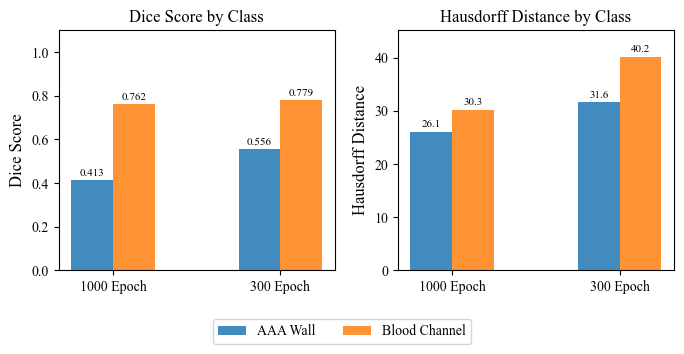

In [24]:
import nibabel as nib
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff

# --- Plot Config (IEEE-inspired but tweaked for readability) ---
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (7, 3.2),
    'axes.grid': False
})

# --- Utility Functions ---
def load_nifti(file_path):
    """Load NIfTI file and return data as a numpy array."""
    try:
        return nib.load(file_path).get_fdata()
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    
def pad_to_even_dims(data, ref_shape):
    """Pad data to match reference shape with even dimensions."""
    if data is None:
        return None
    pad_width = [(0, 1 if d % 2 else 0) for d in data.shape]
    padded = np.pad(data, pad_width, mode='constant')
    return padded[:ref_shape[0], :ref_shape[1], :ref_shape[2]]

# --- Metric Functions ---
def calculate_dice_score(pred, target):
    pred = torch.from_numpy(pred).float().flatten()
    target = torch.from_numpy(target).float().flatten()
    intersection = (pred * target).sum()
    return (2. * intersection / (pred.sum() + target.sum() + 1e-8)).item()

def calculate_hausdorff_distance(pred, target):
    pred_pts, tgt_pts = np.where(pred), np.where(target)
    if pred_pts[0].size == 0 or tgt_pts[0].size == 0:
        return np.inf
    return max(directed_hausdorff(np.array(pred_pts).T, np.array(tgt_pts).T)[0],
               directed_hausdorff(np.array(tgt_pts).T, np.array(pred_pts).T)[0])

def compute_metrics(label, gt):
    """Compute Dice & Hausdorff metrics for each class."""
    if label is None or gt is None:
        return None, None
    dice, hausdorff = {}, {}
    for class_id, class_name in [(1, 'AAA Wall'), (2, 'Blood Channel')]:
        pred_cls = (label == class_id).astype(int)
        tgt_cls = (gt == class_id).astype(int)
        dice[class_name] = calculate_dice_score(pred_cls, tgt_cls)
        hausdorff[class_name] = calculate_hausdorff_distance(pred_cls, tgt_cls)
    return dice, hausdorff

# --- Subject Processing ---
def process_subject(subject_id, datasets, base_path):
    gt_path = f"{base_path}/Dataset001_raw_aaa/labelsTs/aaa_{subject_id}.nii.gz"
    gt = load_nifti(gt_path)
    if gt is None:
        return None, None

    dice_all = {name: {'AAA Wall': [], 'Blood Channel': []} for name in datasets}
    hausdorff_all = {name: {'AAA Wall': [], 'Blood Channel': []} for name in datasets}

    for name, ds_id in datasets.items():
        label_path = f"{base_path}/{ds_id}/outputTs/aaa_{subject_id}.nii.gz"
        label = pad_to_even_dims(load_nifti(label_path), gt.shape)
        dice, haus = compute_metrics(label, gt)
        if dice and haus:
            for cls in ['AAA Wall', 'Blood Channel']:
                dice_all[name][cls].append(dice[cls])
                hausdorff_all[name][cls].append(haus[cls])
    return dice_all, hausdorff_all

# --- Plotting ---
def plot_metrics(dice, hausdorff, datasets):
    labels = list(datasets.keys())
    class_names = ['AAA Wall', 'Blood Channel']
    colors = ['#1f77b4', '#ff7f0e']
    bar_width = 0.25
    x = np.arange(len(labels))

    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Dice plot
    for i, cls in enumerate(class_names):
        means = [np.mean(dice[name][cls]) for name in labels]
        bars = ax1.bar(x + i * bar_width, means, bar_width, label=cls, color=colors[i], alpha=0.85)
        for bar in bars:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.3f}',
                     ha='center', va='bottom', fontsize=8)
    ax1.set_title('Dice Score by Class')
    ax1.set_ylabel('Dice Score')
    ax1.set_xticks(x + bar_width / 2)
    ax1.set_xticklabels(labels)
    ax1.set_ylim(0, 1.1)

    # Hausdorff plot
    for i, cls in enumerate(class_names):
        means = [np.mean([v for v in hausdorff[name][cls] if v != np.inf]) for name in labels]
        bars = ax2.bar(x + i * bar_width, means, bar_width, label=cls, color=colors[i], alpha=0.85)
        for bar in bars:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{bar.get_height():.1f}',
                     ha='center', va='bottom', fontsize=8)
    ax2.set_title('Hausdorff Distance by Class')
    ax2.set_ylabel('Hausdorff Distance')
    ax2.set_xticks(x + bar_width / 2)
    ax2.set_xticklabels(labels)
    max_y = max([max([np.mean([s for s in hausdorff[name][cls] if s != np.inf]) for name in labels]) for cls in class_names])
    ax2.set_ylim(0, max_y + 5)

    # Shared legend
    fig.legend(class_names, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(class_names))

    plt.tight_layout()
    plt.savefig('metrics_comparison_by_class.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- Main ---
base_path = "data/nnunet_raw"
datasets = {
    # 'Supervised': 'Dataset001_raw_aaa',
    # 'Original Synthseg': 'Dataset002_origin_synthseg',
    '1000 Epoch': 'Dataset003_perlin_synthseg',
    '300 Epoch': 'Dataset004_perlin_synthseg',
}
subject_ids = [f"{i:03d}" for i in range(16, 21)]
all_dice = {name: {'AAA Wall': [], 'Blood Channel': []} for name in datasets}
all_hausdorff = {name: {'AAA Wall': [], 'Blood Channel': []} for name in datasets}

for sid in subject_ids:
    dice, haus = process_subject(sid, datasets, base_path)
    if dice and haus:
        for name in datasets:
            for cls in ['AAA Wall', 'Blood Channel']:
                all_dice[name][cls].extend(dice[name][cls])
                all_hausdorff[name][cls].extend(haus[name][cls])

plot_metrics(all_dice, all_hausdorff, datasets)

In [5]:
import os
import nibabel as nib
import numpy as np
from pathlib import Path

# List of folders to search
folders = [
    "data/nnunet_raw/Dataset001_raw_aaa/labelsTs",
    "data/nnunet_raw/Dataset001_raw_aaa/outputTs",
    "data/nnunet_raw/Dataset002_origin_synthseg/outputTs",
    "data/nnunet_raw/Dataset003_perlin_synthseg/outputTs",
    "data/nnunet_raw/Dataset004_perlin_synthseg/outputTs",
]
output_root = Path("data/nnunet_flipped")

def flip_vertically_nifti(input_path, output_path):
    img = nib.load(input_path)
    data = img.get_fdata()

    # Flip vertically (up-down = axis 2 for axial NIfTI)
    flipped_data = np.flip(data, axis=2)

    # Handle segmentation dtype
    if np.all(flipped_data == flipped_data.astype(int)):
        # Convert to int if it's essentially integer-valued
        flipped_data = flipped_data.astype(np.int16)

    flipped_img = nib.Nifti1Image(flipped_data, img.affine, img.header)
    nib.save(flipped_img, output_path)

for folder in folders:
    folder_path = Path(folder)
    for nii_path in folder_path.rglob("*.nii.gz"):
        relative_path = nii_path.relative_to(folder_path)
        output_dir = output_root / folder
        output_dir.mkdir(parents=True, exist_ok=True)

        output_path = output_dir / (nii_path.stem + "_flipped.nii.gz")
        print(f"Flipping: {nii_path} -> {output_path}")
        flip_vertically_nifti(nii_path, output_path)

Flipping: data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_020.nii.gz -> data/nnunet_flipped/data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_020.nii_flipped.nii.gz
Flipping: data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_018.nii.gz -> data/nnunet_flipped/data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_018.nii_flipped.nii.gz
Flipping: data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_017.nii.gz -> data/nnunet_flipped/data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_017.nii_flipped.nii.gz
Flipping: data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_016.nii.gz -> data/nnunet_flipped/data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_016.nii_flipped.nii.gz
Flipping: data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_019.nii.gz -> data/nnunet_flipped/data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_019.nii_flipped.nii.gz
Flipping: data/nnunet_raw/Dataset001_raw_aaa/outputTs/aaa_020.nii.gz -> data/nnunet_flipped/data/nnunet_raw/Dataset001_raw_aaa/outputTs/aaa_020.nii_flipped.nii.gz
Flipping: data/nnunet_